A quick project on AirBnB data.

The dataset is found here: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data 

This is a quick EDA as well as a quick classification model based on description, neighbourhood and room type.
The classes are chosen as different price ranges based on the percentiles of the prices.


Disclaimer:
This is not how i would usually go about making a model or doing EDA, just showing my familiarity with some packages and concepts as well as giving a quick overview of my programming style. There are therefore some things done ad hoc such as choosing the intervals for the different price classes. 


In [44]:
# Imports
# Handling data
import numpy as np
import pandas as pd

# BoW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords

# For plots
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# ML
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [96]:
df = pd.read_csv("AB_NYC_2019.csv")

In [97]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [98]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [78]:
df.last_review.fillna('',inplace=true)
df.last_review.fillna('',inplace=true)
df = df.dropna()

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38821 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38821 non-null  int64  
 1   name                            38821 non-null  object 
 2   host_id                         38821 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38821 non-null  object 
 5   neighbourhood                   38821 non-null  object 
 6   latitude                        38821 non-null  float64
 7   longitude                       38821 non-null  float64
 8   room_type                       38821 non-null  object 
 9   price                           38821 non-null  int64  
 10  minimum_nights                  38821 non-null  int64  
 11  number_of_reviews               38821 non-null  int64  
 12  last_review                     

We can see that the columns that are not numerical are name, host Name, neighbourhood, neighbourhood group, room type and last review (date)
Lets check some of them out to try and understand what sort of data we are dealing with for these columns. Then make a Correlation Matrix and see if we can improve the correlation matrix by making some of these non numerical columns into some sort of numerical data.

In [81]:
for c in df.columns[0:5]:
    print("\n"+str(c))
    print(df[c].unique())


id
[    2539     2595     3831 ... 36438336 36442252 36455809]

name
['Clean & quiet apt home by the park' 'Skylit Midtown Castle'
 'Cozy Entire Floor of Brownstone' ... 'Seas The Moment'
 '1B-1B apartment near by Metro' 'Cozy Private Room in Bushwick, Brooklyn']

host_id
[     2787      2845      4869 ... 211644523 273841667  74162901]

host_name
['John' 'Jennifer' 'LisaRoxanne' ... 'Prince' 'David & Amy' 'Rusaa']

neighbourhood_group
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


In [82]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.00,0.59,-0.01,0.10,-0.01,-0.07,-0.33,0.29,0.10,0.01
host_id,0.59,1.00,0.01,0.14,0.01,-0.05,-0.14,0.30,0.15,0.16
latitude,-0.01,0.01,1.00,0.09,0.03,0.02,-0.01,-0.01,0.00,-0.02
longitude,0.10,0.14,0.09,1.00,-0.16,-0.06,0.05,0.15,-0.09,0.10
price,-0.01,0.01,0.03,-0.16,1.00,0.03,-0.04,-0.03,0.05,0.08
minimum_nights,-0.07,-0.05,0.02,-0.06,0.03,1.00,-0.07,-0.12,0.07,0.10
number_of_reviews,-0.33,-0.14,-0.01,0.05,-0.04,-0.07,1.00,0.55,-0.06,0.19
reviews_per_month,0.29,0.30,-0.01,0.15,-0.03,-0.12,0.55,1.00,-0.01,0.19
calculated_host_listings_count,0.10,0.15,0.00,-0.09,0.05,0.07,-0.06,-0.01,1.00,0.18
availability_365,0.01,0.16,-0.02,0.10,0.08,0.10,0.19,0.19,0.18,1.00


We can see that few of our current numerical feature has a good correlation with the price, lets make dummy variables for the neighbourhood groups as well as the room types and see if that gives us more correlation.

In [83]:
df2 = pd.concat([df,pd.get_dummies(df.neighbourhood_group)],axis=1,join='inner')
df2 = pd.concat([df2,pd.get_dummies(df.room_type)],axis=1,join='inner')

In [84]:
corr = df2.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
id,1.00,0.59,-0.01,0.10,-0.01,-0.07,-0.33,0.29,0.10,0.01,0.05,-0.04,-0.03,0.09,0.02,-0.07,0.05,0.06
host_id,0.59,1.00,0.01,0.14,0.01,-0.05,-0.14,0.30,0.15,0.16,0.07,-0.11,-0.01,0.14,0.04,-0.08,0.06,0.07
latitude,-0.01,0.01,1.00,0.09,0.03,0.02,-0.01,-0.01,0.00,-0.02,0.33,-0.68,0.60,0.02,-0.19,-0.02,0.02,0.01
longitude,0.10,0.14,0.09,1.00,-0.16,-0.06,0.05,0.15,-0.09,0.10,0.22,0.00,-0.42,0.63,-0.30,-0.18,0.17,0.03
price,-0.01,0.01,0.03,-0.16,1.00,0.03,-0.04,-0.03,0.05,0.08,-0.05,-0.09,0.17,-0.09,-0.02,0.29,-0.27,-0.06
minimum_nights,-0.07,-0.05,0.02,-0.06,0.03,1.00,-0.07,-0.12,0.07,0.10,-0.02,-0.03,0.06,-0.03,-0.01,0.07,-0.07,-0.01
number_of_reviews,-0.33,-0.14,-0.01,0.05,-0.04,-0.07,1.00,0.55,-0.06,0.19,0.01,0.01,-0.04,0.04,0.01,-0.02,0.02,-0.02
reviews_per_month,0.29,0.30,-0.01,0.15,-0.03,-0.12,0.55,1.00,-0.01,0.19,0.04,-0.05,-0.05,0.12,0.03,-0.04,0.04,0.01
calculated_host_listings_count,0.10,0.15,0.00,-0.09,0.05,0.07,-0.06,-0.01,1.00,0.18,-0.02,-0.10,0.12,-0.03,-0.01,0.07,-0.07,-0.00
availability_365,0.01,0.16,-0.02,0.10,0.08,0.10,0.19,0.19,0.18,1.00,0.07,-0.06,-0.04,0.10,0.06,-0.03,0.01,0.06


We can see that both neigbourhood group and room type is pretty well correlated with price. Probably neighbourhood would have an even higher correlation with the price, which could be interesting to have a look at.

Up next we want to plot the meanprice as a function of longitude and latitude in a 3d barchart. We do this to get a better pricture of the price differences in the differnt areas.

After that we will do a quick classification model for different priceclasses. Since we have very little information on the actual rooms rented, size and otherwise it will be difficult to estimate prices however. However we will do this using a bag of word approach on the name of the listing as well as additional interesting inormation

## 3D - Barchart with price over latitude and longitude

In [85]:
# Create Bins and putting the values into a grid depending on latitude and longitude
df_bar = df.copy(True)

numberOfBins = 15
df_bar["latitude"] = pd.cut(df_bar['latitude'], bins = numberOfBins) #, labels = group_names)
df_bar["longitude"] = pd.cut(df_bar['longitude'], bins = numberOfBins) #, labels = group_names)

latitudes = df_bar.latitude.unique()
longitudes = df_bar.longitude.unique()

matrix = pd.DataFrame(columns=['price','lat','lon'])

for lat in latitudes:
    corrLat = df_bar[df_bar['latitude'] == lat]
    for lon in longitudes:
        corrLatLong = corrLat[corrLat['longitude'] == lon]
        meanPrice = corrLatLong['price'].mean()#.median()
        new_entries = pd.DataFrame([[meanPrice, lat, lon]], columns=['price','lat','lon'])
        matrix = pd.concat([matrix, new_entries],ignore_index=True, sort=False) #)

matrix = matrix.dropna(axis=0,how='any') # Removes the "empty" squares from our graph.

X_axis = matrix['lat'].values
Y_axis = matrix['lon'].values
Z_axis = matrix['price'].values

In [86]:
# Gives us the middle of our intervals as the point instead of the 
def midRangeOfInterval(axis):
    for i in range(len(axis)):
        strInterval = str(axis[i])
        strInterval = strInterval.split(',')
        int1 = strInterval[0]
        int2 = strInterval[1]
        firstVal = float(int1[1:])
        secVal = float(int2[1:-1])
        axis[i] = (firstVal+secVal)/2
    return axis

X_axis = midRangeOfInterval(X_axis)
Y_axis = midRangeOfInterval(Y_axis)

<function matplotlib.pyplot.show(close=None, block=None)>

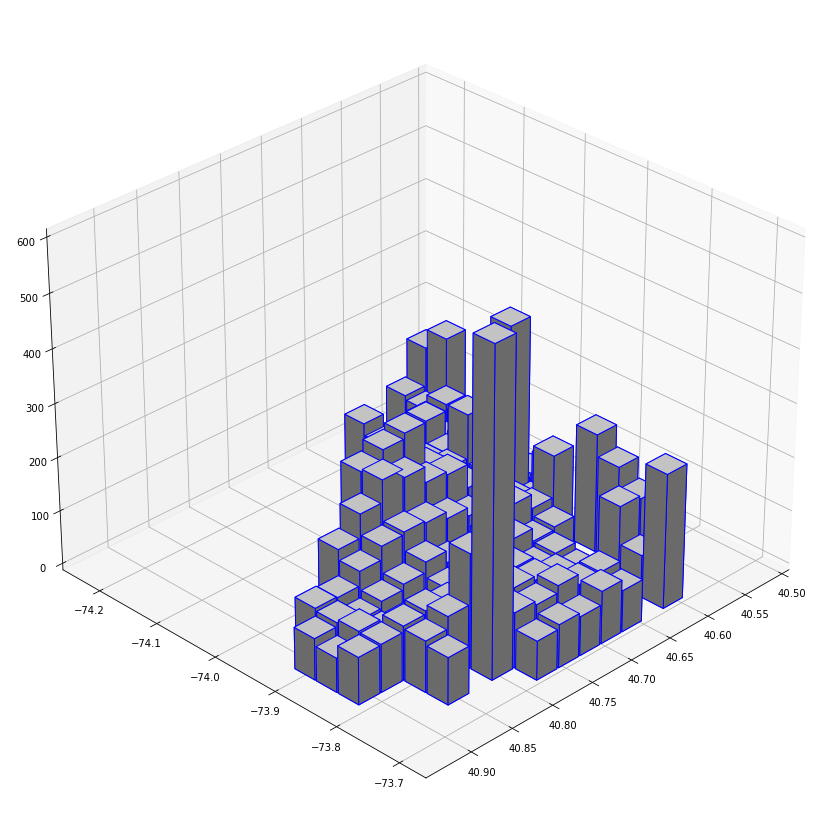

In [87]:
plt.rcParams['figure.figsize'] = (15, 15)
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# Gives us the x, y and z "start values" values
xpos = X_axis
ypos = Y_axis
zpos = np.zeros(len(xpos))

# Makes sure our bars look proportional in the graph
xspan = xpos.max() - xpos.min()
yspan = ypos.max() - ypos.min()
dx = [xspan/numberOfBins] * len(xpos)
dy = [yspan/numberOfBins] * len(ypos)
# Our price values.
dz = Z_axis
    
#ax1.view_init(30, 100)
ax1.view_init(30, 45)
#ax1.view_init(90, 0)

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, edgecolor='blue', color = 'w')
plt.show

From the barplot above we can see that a lot of the quadrants have similar prices to their "neighbours" with a few exceptions, most noteworthy being the largest bar when you look at the graph. The question is if this is because of an extra expensive area or because of an outlier and there being very few rooms to rent in that specific quadrant. In this notebook i won't delve farther into this analysis, but can be interesting to keep in min if you want to do this type of analysis.

Next up we want to try doing a very quick prediction of what priceclass a listing belongs to based on the name of the listing, the neighbourhood and the room_type-

First we want to define a few different priceclasses for this dataset. Lets start with a visual to get a feel of the distribution of the prices.

<AxesSubplot:>

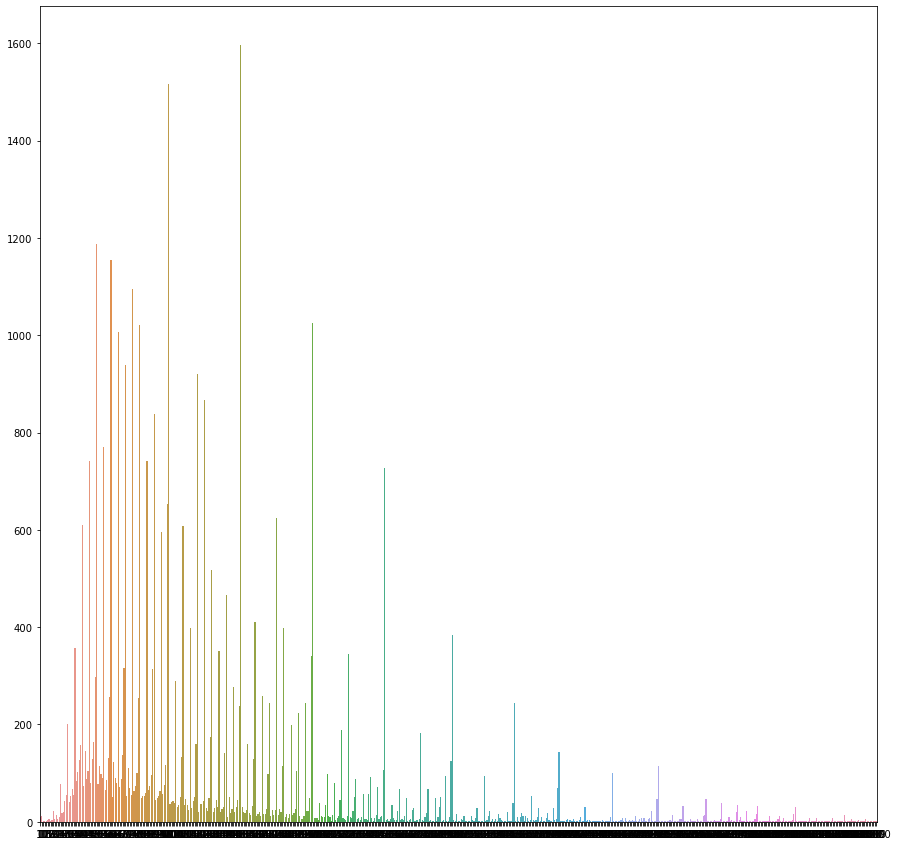

In [88]:
uniquePrices = sorted(df['price'].unique().tolist())
prices = df['price'].tolist()
priceCount = []
for price in uniquePrices:
    priceCount.append(prices.count(price))
sns.barplot(uniquePrices,priceCount)

In [89]:
df['price'].describe()

count    38821.000000
mean       142.332526
std        196.994756
min          0.000000
25%         69.000000
50%        101.000000
75%        170.000000
max      10000.000000
Name: price, dtype: float64

Lets split our data into 4 groups low Prices, midPrices, midHighprices and high prices based on percentiles. Normally this would be done more carefully after more statistical anlaysis but since this is just a quick showcase of my abilities not a lot of time was devoted to finding the perfect bounds.

In [90]:
for p in [x*5+25 for x in range(16)]:
    print(p, ': ' , np.percentile(df['price'],p))

25 :  69.0
30 :  75.0
35 :  80.0
40 :  90.0
45 :  99.0
50 :  101.0
55 :  118.0
60 :  125.0
65 :  140.0
70 :  150.0
75 :  170.0
80 :  190.0
85 :  206.0
90 :  250.0
95 :  330.0
100 :  10000.0


As we can see, the bulk of the prices are concentrated around 100 ± 50. We don't want the classes to be too easily confused in our modell therefore we chose 0-50 as the first interval, then we chose 50-80 as the second interval and lastly 80-95 and 95-100 as the last two intervals.
Lets look at these intervalls graphically.

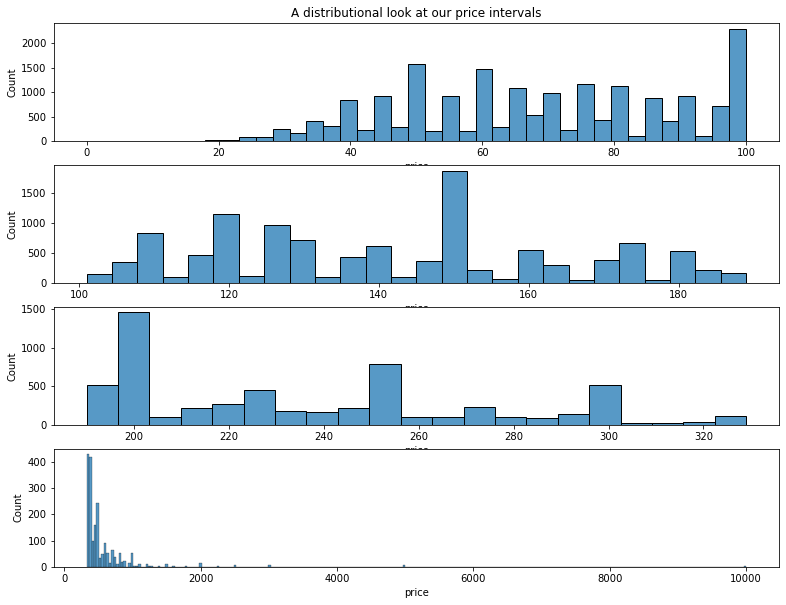

In [91]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (13,10))

ax[0].set_title('A distributional look at our price intervals')
lowerBound = 0
for i, upperBound in enumerate([50,80,95,100]):
    sns.histplot(df[(df['price']>=np.percentile(df['price'],lowerBound)) & (df['price']<np.percentile(df['price'],upperBound))], x="price",ax= ax[i])
    lowerBound = upperBound
plt.show()

Alright then, lets make our prices into these four classes and try to predict which ones a test group belongs to based on name and possibly neighbourhood group and room_type as well.

In [92]:
df_bow = df.copy(True)
df_bow 
# Preprocessing, We want to put our prices into a few different categories based on our quick statistical analysis earlier.
bins = (0, np.percentile(df['price'],20),np.percentile(df['price'],50), np.percentile(df['price'],80), np.percentile(df['price'],95), 10000)
group_names = ['low_price','midLow_price','mid_price', 'midHigh_price','high_price',]
df_bow["price"] = pd.cut(df_bow['price'], bins = bins , labels = group_names)
print(df_bow["price"].unique())
df_bow['price'].isnull().sum()

['mid_price', 'midHigh_price', 'midLow_price', 'low_price', 'high_price', NaN]
Categories (5, object): ['low_price' < 'midLow_price' < 'mid_price' < 'midHigh_price' < 'high_price']


10

We can see that 10 objects are of value null, these should be removed and then we should turn these classes into numerical values that our model can understand.

In [93]:
df_bow = df_bow[~df_bow["price"].isnull()]
n = {'low_price':0,'mid_price':1,'midHigh_price':2, 'high_price':3}
df_bow = df_bow.replace({"price":n})
df_bow.price.unique()

array([2, 3, 1, 0, 4])

The next step is choosing the most appropriate bag of words model, here I have tried using only name, using name and place as well as name, place and room type at the same time. These three alternatives have been tried with and without TFIDF transformation.

In [94]:
# Making columns for name+place and name+place and room
df_bow['name+place'] = df_bow['name'] + " " + df_bow['neighbourhood']
df_bow['name+place+room_type'] = df_bow['name+place'] + " " + df_bow['room_type']

# Creating the Countvectorizer and the TF-IDF transformer
vectorizer = CountVectorizer(max_df=0.9, min_df=3, max_features=10000, stop_words=stopwords.words("english")) #, ngram_range=(1,2))  #, max_features=1000000)
tfidfconverter = TfidfTransformer()

# Trying out if TFIDF improves the accuracy or not as well as if its best to add place and/or room_typ to the name (description of the place).
X1 = vectorizer.fit_transform(df_bow["name+place"])
X2 = tfidfconverter.fit_transform(X1)
X3 = vectorizer.fit_transform(df_bow["name"])
X4 = tfidfconverter.fit_transform(X3)
X5 = vectorizer.fit_transform(df_bow["name+place+room_type"]) # This one worked best
X6 = tfidfconverter.fit_transform(X5)

X = X5

Here we want to crossvalidate our model here for 5 different folds to make sure we are not overfitting our model. What is used is a XGboost classifyer meaning an extreme gradient boosted decision tree classification model.

In [95]:
scores = cross_val_score(XGBClassifier(), X, df_bow["price"].to_numpy(), scoring='accuracy')
for score in scores:
    print(score)

0.5332989823521834
0.5470239628961607
0.5371038392166967
0.5505024478227261
0.530662200463798


So our predicting model performed an accuracy at around 68 % in the classification of the four classes. This is quite a bit better than just guessing class 0 which would have given us around 50 % accuracy. Given that this is a classification of prices based on just area room type and a very short wirtten description the results are satisfactory.